# NBA Draft Code
## Dan McDonough
## June 28th, 2021

This notebook is a quick pass at understanding value of draft picks in the NBA. An important item to note is that I'm assessing value of picks agnostic to the team that is drafting. In practice, I think pick value likely varies quite a bit based on who is drafting, for several reasons:
- Varied ability to scout, develop, and retain talent impacts the expected lifetime value of the player selected
- Varied ability to convert picks into higher expected value players via trade changes the value of the asset
- Varied ability to sign free agents, changes the importance of acquiring elite talent via the draft

Nonetheless, here is a quick view at what can be expected with any particular pick.

### 1. Data Overview

In [1]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import pandas as pd
import random
import timeit
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy as sp

I've scraped the data from basketball reference, which conveniently maintains tables of each year's draft with the players' career statistics included. I've chosen to look at 2005-present, which represents the time periods where 60 picks were made in each draft.

In [2]:
# years = list(range(2005,2021))

# for year in years:
#     url = 'https://www.basketball-reference.com/draft/NBA_'+str(year)+'.html'
#     response = requests.get(url)
#     soup = BeautifulSoup(response.text, "html.parser")

#     datarows = soup.findAll('tr')

#     yearlist = []
#     rank = list(range(1,len(datarows)-3))
#     team = []
#     player = []
#     college = []
#     years = []
#     minutes = []
#     mpg = []
#     ws = []
#     ws48 = []
#     bpm = []
#     vorp = []

#     for i in range(2,len(datarows)):
#         if ((i == 32) | (i == 33)):
#             continue
#         yearlist.append(year)
#         team.append(str(datarows[i].findAll('td')[1].findAll('a')).split('>')[1].split('<')[0])
#         try:
#             player.append(str(datarows[i].findAll('td')[2].findAll('a')).split('>')[1].split('<')[0])
#         except:
#             player.append(str(datarows[43].findAll('td')[2]).split('>')[1].split('<')[0])
#         try:
#             college.append(str(datarows[i].findAll('td')[3].findAll('a')).split('>')[1].split('<')[0])
#         except:
#             college.append('')
#         years.append(str(datarows[i].findAll('td')[4]).split('>')[1].split('<')[0])
#         minutes.append(str(datarows[i].findAll('td')[6]).split('>')[1].split('<')[0])
#         mpg.append(str(datarows[i].findAll('td')[13]).split('>')[1].split('<')[0])
#         ws.append(str(datarows[i].findAll('td')[17]).split('>')[1].split('<')[0])
#         ws48.append(str(datarows[i].findAll('td')[18]).split('>')[1].split('<')[0])
#         bpm.append(str(datarows[i].findAll('td')[19]).split('>')[1].split('<')[0])
#         vorp.append(str(datarows[i].findAll('td')[20]).split('>')[1].split('<')[0])

#     annual_df = pd.DataFrame({'Year':yearlist,'Rank':rank,'Team':team,'Player':player,'College':college,
#                               'Years':years,'Minutes':minutes,'MPG':mpg,'WS':ws,'WS48':ws48,'BPM':bpm,'VORP':vorp})
    
#     if year == 2005:
#         total_df = annual_df.copy()
#     else:
#         total_df = pd.concat([total_df,annual_df],axis=0)
    
#     time.sleep(1)

Save file for future use

In [3]:
# total_df.to_csv('draft.csv',index=False)

In [4]:
total_df = pd.read_csv('draft.csv')
templist = list(total_df.columns)
templist[1] = 'Pick'
total_df.columns = templist

In [5]:
total_df[total_df['Year']==2020].head(14)

,Year,Pick,Team,Player,College,Years,Minutes,MPG,WS,WS48,BPM,VORP
900,2020,1,MIN,Anthony Edwards,Georgia,1.0,2314.0,32.1,0.8,0.017,-2.6,-0.3
901,2020,2,GSW,James Wiseman,Memphis,1.0,836.0,21.4,0.7,0.042,-5.4,-0.7
902,2020,3,CHO,LaMelo Ball,NaN,1.0,1469.0,28.8,2.8,0.093,1.9,1.4
903,2020,4,CHI,Patrick Williams,Florida State,1.0,1983.0,27.9,2.5,0.060,-2.7,-0.3
904,2020,5,CLE,Isaac Okoro,Auburn,1.0,2173.0,32.4,0.9,0.020,-5.0,-1.6
905,2020,6,ATL,Onyeka Okongwu,USC,1.0,601.0,12.0,1.9,0.155,-1.3,0.1
906,2020,7,DET,Killian Hayes,NaN,1.0,670.0,25.8,-1.1,-0.081,-7.3,-0.9
907,2020,8,NYK,Obi Toppin,Dayton,1.0,683.0,11.0,1.5,0.109,-1.0,0.2
908,2020,9,WAS,Deni Avdija,NaN,1.0,1257.0,23.3,1.2,0.046,-3.9,-0.6
909,2020,10,PHO,Jalen Smith,Maryland,1.0,156.0,5.8,0.1,0.022,-6.2,-0.2


### 2. Making the League

At a minimum, teams want a player who will be good enough to stick around in the league. I'll start by assessing the probability of each draft pick resulting in a player who makes a full career of it in the NBA.

To begin, I need to define "a full career" more specifically. For players drafted at least 10 years ago, I've looked to see if the player played at least 10 years. My rationale is that players are at oldest ~ 22 years old when drafted, and are in their prime through 32 years old, so anything short of this amount of time is likely before the player's physical prime has ended.

For players drafted more recently, I check to see if the player is still in the league (note: a one year buffer is added when comparing years played to years since draft, since basketball reference does not give credit for years that are entirely missed due to injury).

In [6]:
total_df['years_since'] = 2021-total_df['Year']
total_df['Years'].fillna(0,inplace=True)

def stay(x):
    if ((x['Year'] <= 2010) & (x['Years'] < 10)):
        return 0
    elif ((x['Year'] > 2010) & ((x['Years']+1) < x['years_since'])):
        return 0
    else:
        return 1

total_df['stay_ind'] = total_df.apply(stay,axis=1)

Something to note is that it takes time for players to wash out of the league, so the % of players still in the league will vary based on how long it has been since each class was drafted, which you can see below.

Text(0.5,0,'Years Since Draft')

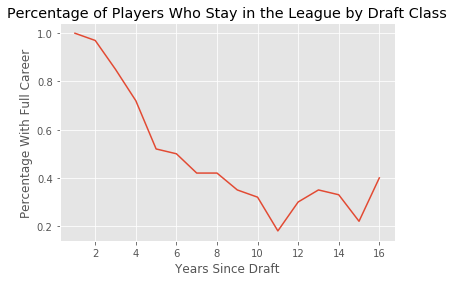

In [7]:
# total_df.groupby('years_since')['stay_ind'].mean().round(2).plot()
plot_df = pd.DataFrame(total_df.groupby('years_since')['stay_ind'].mean().round(2)).reset_index()
plt.plot(plot_df['years_since'],plot_df['stay_ind'])
plt.title('Percentage of Players Who Stay in the League by Draft Class')
plt.ylabel('Percentage With Full Career')
plt.xlabel('Years Since Draft')

Overall, 49% of players have stayed in the league, but this number declines to 31% after 9 years. I've chosen 9 years as a fully-developed number because this is a first-round rookie deal (4 years) + an RFA contract (3 years) + the injury buffer (1 year) + the first year in which they were no longer in the league.

In [8]:
print('All Draft Classes: ',round(total_df['stay_ind'].mean(),2))
print('Developed Draft Classes: ',round(total_df[total_df['years_since']>=9]['stay_ind'].mean(),2))

All Draft Classes:  0.49
Developed Draft Classes:  0.31


There is a clear relationship between draft order and likelihood of staying in the league.

In [9]:
X = sm.add_constant(total_df['Pick'])
y = total_df['stay_ind']
logm=sm.GLM(y,X,family=sm.families.Binomial()).fit()
print(logm.summary())
print()
print('Baseline accuracy: ',round(y.mean(),2))
print('Model accuracy: ',round((y == logm.predict().round()).mean(),2))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               stay_ind   No. Observations:                  960
Model:                            GLM   Df Residuals:                      958
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -578.81
Date:                Mon, 28 Jun 2021   Deviance:                       1157.6
Time:                        15:18:02   Pearson chi2:                     957.
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5811      0.152     10.432      0.000       1.284       1.878
Pick          -0.0535      0.004    -12.054      0.0

The model estimate somewhat underestimates high lottery picks and overestimates later lottery picks, but generally describes the trend.

Text(0.5,1,'Probability of Staying in the League by Pick')

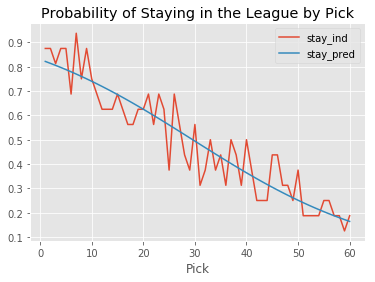

In [10]:
total_df['stay_pred'] = logm.predict()
model_df1 = total_df.groupby('Pick').agg({'stay_ind':'mean','stay_pred':'mean'})
model_df1.plot()
plt.title('Probability of Staying in the League by Pick')

Looking at fully-developed classes, we see a similar relationship.

In [11]:
older_df = total_df[total_df['years_since']>=9].copy()

X = sm.add_constant(older_df['Pick'])
y = older_df['stay_ind']
logm=sm.GLM(y,X,family=sm.families.Binomial()).fit()
print(logm.summary())
print()
print('Baseline accuracy: ',1-round(y.mean(),2))
print('Model accuracy: ',round((y == logm.predict().round()).mean(),2))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               stay_ind   No. Observations:                  480
Model:                            GLM   Df Residuals:                      478
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -245.38
Date:                Mon, 28 Jun 2021   Deviance:                       490.77
Time:                        15:18:03   Pearson chi2:                     497.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9438      0.208      4.527      0.000       0.535       1.352
Pick          -0.0654      0.007     -8.825      0.0

Text(0.5,1,'Probability of Staying in the League by Pick')

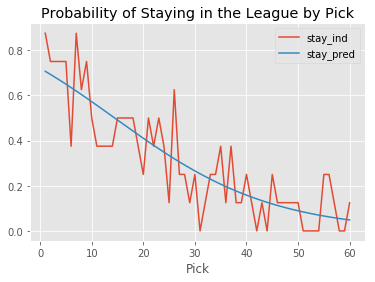

In [12]:
older_df['stay_pred'] = logm.predict()
model_df2 = older_df.groupby('Pick').agg({'stay_ind':'mean','stay_pred':'mean'})
model_df2.plot()
plt.title('Probability of Staying in the League by Pick')

Below, I've included the predicted probabilty by each draft position of the player making the league (using all draft classes and just the older classes). I would err towards the older-class prediction as a truer measure, and note the bias regarding high/low lottery picks.

In [13]:
model_df3 = pd.concat([model_df1['stay_pred'],model_df2['stay_pred']],axis=1).round(2)
model_df3.columns = ['All Classes Prediction','Older Classes Prediction']
model_df3

,All Classes Prediction,Older Classes Prediction
Pick,,
1,0.82,0.71
2,0.81,0.69
3,0.81,0.68
4,0.80,0.66
5,0.79,0.65
6,0.78,0.63
7,0.77,0.62
8,0.76,0.60
9,0.75,0.59


One thing I noticed is the gap between these two predictions varies based on draft pick (peaking in the 20-35 range). I think this is likely due to a few reasons:
- Lottery picks a very unlikely to leave the league early, but are also less likely to leave overall
- Late seconds are likely to wash out, but are also likely to leave early given the shorter contracts
- The middle bucket is unlikely to make it for a full career, but there is a lot of variability in when they leave the league

Text(0.5,1,'Discrepancy in Stay Probabilities by Draft Pick')

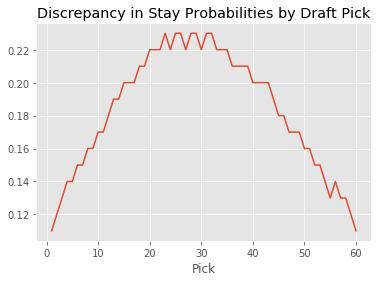

In [14]:
(model_df3['All Classes Prediction'] - model_df3['Older Classes Prediction']).plot()
plt.title('Discrepancy in Stay Probabilities by Draft Pick')

Below, you can see the development of this trend, with later picks leaving sooner than early picks.

Text(0.5,1,'Player Outcome By Draft Pick by Year')

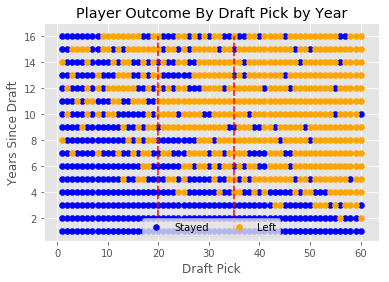

In [15]:
plt.scatter(total_df[total_df['stay_ind']==1]['Pick'],total_df[total_df['stay_ind']==1]['years_since'],color='blue')
plt.scatter(total_df[total_df['stay_ind']==0]['Pick'],total_df[total_df['stay_ind']==0]['years_since'],color='orange')
plt.xlabel('Draft Pick')
plt.ylabel('Years Since Draft')
plt.legend(labels=['Stayed','Left'],loc='lower center',ncol=2)
plt.plot([35]*16,range(1,17),linestyle='--',color='red')
plt.plot([20]*16,range(1,17),linestyle='--',color='red')
plt.title('Player Outcome By Draft Pick by Year')

### 3. Minutes Played

In addition to staying in the league, I want to understand if the player actually played.

In [16]:
def minutes_bucket(x):
    if x >= 30:
        return '3. 30+'
    elif x >= 20:
        return '2. 20-30'
    elif x >= 10:
        return '1. 10-20'
    else:
        return '0. 0-10'

total_df['MPG'].fillna(0,inplace=True)
total_df['10min_ind'] = total_df['MPG'].apply(lambda x: 1 if x >= 10 else 0) * total_df['stay_ind']
total_df['min_bucket'] = total_df['MPG'].apply(minutes_bucket)

older_df['MPG'].fillna(0,inplace=True)
older_df['10min_ind'] = older_df['MPG'].apply(lambda x: 1 if x >= 10 else 0) * older_df['stay_ind']
older_df['min_bucket'] = older_df['MPG'].apply(minutes_bucket)

Players who stayed in the league overwhelmingly average at least 10+ minutes, so I'll assume anyone who stayed in the league also gave a meaningful number of minutes, and will now turn my focus to player quality.

In [17]:
round(total_df.groupby(['stay_ind','10min_ind'])['stay_pred'].count()/len(total_df),2)

stay_ind  10min_ind
0         0            0.51
1         0            0.05
          1            0.44
Name: stay_pred, dtype: float64

In [18]:
round(older_df.groupby(['stay_ind','10min_ind'])['stay_pred'].count()/len(older_df),2)

stay_ind  10min_ind
0         0            0.69
1         1            0.31
Name: stay_pred, dtype: float64

### 4. Player Quality: Box Plus Minus

In addition to understanding whether and player makes the league (and gives meaningful minutes), the next natural question is how much value is this player contributing. 

I've chosen to measure player quality using career box plus minus, which measures value on a per-possession basis.

Looking at average effects, it's clear that players who stayed in the league had higher BPM values (even across different roles), and that within both those and stayed and those who left, BPM was positive correlated with minutes played.

In [19]:
pd.pivot_table(older_df,index='min_bucket',columns='stay_ind',values='BPM',aggfunc='mean').round(1)

stay_ind,0,1
min_bucket,,
0. 0-10,-6.7,NaN
1. 10-20,-2.6,-0.9
2. 20-30,-1.1,-0.4
3. 30+,1.0,2.6


From this table I will create three categories for player roles (there are very few players who stayed in the league but were in the 10-20 minute bucket, so I collapsed to two minutes buckets).

In [20]:
def roles(x):
    if x['stay_ind'] == 0:
        return '0. Did Not Stay'
    elif x['MPG'] >= 25:
        return '2. 25+'
    else:
        return '1. 0-25'
    
older_df['role'] = older_df.apply(roles,axis=1)

In [21]:
older_df.groupby(['role']).agg({'BPM':['count','mean']}).round(1)

BPM     
                count mean
role                      
0. Did Not Stay   270 -3.6
1. 0-25            64 -0.8
2. 25+             83  1.4

Next I want to create buckets for player quality, using the thresholds recommended by basketball reference. Note: these threshold normally describe a single season, and we are describing them to a career metric. Therefore, you can think of the "All NBA" bucket as players who were perennial All-NBA talent (and more likely MVP candidates at their peaks).

In [22]:
def bpm_buckets(x):
    if x >= 6:
        return '6. All NBA'
    elif x >= 4:
        return '5. All Star'
    elif x >= 2:
        return '4. Good Starter'
    elif x >= 0:
        return '3. Starter'
    elif x >= -2:
        return '2. Below Average'
    else:
        return '1. Below Replacement'
    
older_df['bpm_bucket'] = older_df['BPM'].apply(bpm_buckets)

In [23]:
older_df.groupby(['bpm_bucket']).agg({'BPM':['count','mean']}).round(1)

BPM     
                     count mean
bpm_bucket                     
1. Below Replacement   181 -5.1
2. Below Average       135 -1.1
3. Starter              70  0.9
4. Good Starter         19  2.7
5. All Star              6  4.6
6. All NBA               6  6.8

Since BPM is calculated on a per possession basis (without taking into account minutes played), I want to quickly check for the presence of highly-efficient, but low volume players. It doesn't look this poses an issue in the data.

In [24]:
pd.pivot_table(older_df,index='bpm_bucket',columns='role',values='BPM',aggfunc='count')

role,0. Did Not Stay,1. 0-25,2. 25+
bpm_bucket,,,
1. Below Replacement,172.0,7.0,2.0
2. Below Average,74.0,40.0,21.0
3. Starter,21.0,16.0,33.0
4. Good Starter,2.0,1.0,16.0
5. All Star,1.0,NaN,5.0
6. All NBA,NaN,NaN,6.0


Lastly, I want to show examples of each of these categories before progressing to how this relates to draft order, starting with the perennial All-NBA group

In [25]:
older_df[(older_df['BPM']>=6)&(older_df['stay_ind']==1)]

,Year,Pick,Team,Player,College,Years,Minutes,MPG,WS,WS48,BPM,VORP,years_since,stay_ind,stay_pred,10min_ind,min_bucket,role,bpm_bucket
3,2005,4,NOH,Chris Paul,Wake Forest,16.0,37757.0,34.6,189.5,0.241,7.4,89.7,16,1,0.664264,1,3. 30+,2. 25+,6. All NBA
121,2007,2,SEA,Kevin Durant,Texas,13.0,32462.0,36.7,146.7,0.217,6.7,71.6,14,1,0.692763,1,3. 30+,2. 25+,6. All NBA
242,2009,3,OKC,James Harden,Arizona State,12.0,30198.0,34.4,142.0,0.226,6.9,68.1,12,1,0.678680,1,3. 30+,2. 25+,6. All NBA
246,2009,7,GSW,Stephen Curry,Davidson,12.0,26150.0,34.3,112.2,0.206,6.5,56.3,12,1,0.619231,1,3. 30+,2. 25+,6. All NBA
374,2011,15,IND,Kawhi Leonard,San Diego State,10.0,18025.0,31.3,83.3,0.222,6.8,40.1,10,1,0.490859,1,3. 30+,2. 25+,6. All NBA
420,2012,1,NOH,Anthony Davis,Kentucky,9.0,19401.0,34.4,86.8,0.215,6.2,40.0,9,1,0.706496,1,3. 30+,2. 25+,6. All NBA


Next are the perennial all-star talent

In [26]:
older_df[(older_df['BPM']>=4)&(older_df['BPM']<6)&(older_df['stay_ind']==1)]

,Year,Pick,Team,Player,College,Years,Minutes,MPG,WS,WS48,BPM,VORP,years_since,stay_ind,stay_pred,10min_ind,min_bucket,role,bpm_bucket
183,2008,4,SEA,Russell Westbrook,UCLA,13.0,32748.0,34.7,104.8,0.154,4.7,55.3,13,1,0.664264,1,3. 30+,2. 25+,5. All Star
309,2010,10,IND,Paul George,Fresno State,11.0,23664.0,33.5,75.3,0.153,4.1,36.2,11,1,0.572049,1,3. 30+,2. 25+,5. All Star
360,2011,1,CLE,Kyrie Irving,Duke,10.0,19713.0,33.9,68.7,0.167,4.6,32.7,10,1,0.706496,1,3. 30+,2. 25+,5. All Star
389,2011,30,CHI,Jimmy Butler,Marquette,10.0,20933.0,33.1,84.4,0.194,4.5,34.2,10,1,0.265627,1,3. 30+,2. 25+,5. All Star
425,2012,6,POR,Damian Lillard,Weber State,9.0,24779.0,36.3,92.3,0.179,4.8,42.6,9,1,0.634516,1,3. 30+,2. 25+,5. All Star


Next are the perennial good starters

In [27]:
older_df[(older_df['BPM']>=2)&(older_df['BPM']<4)&(older_df['stay_ind']==1)]

,Year,Pick,Team,Player,College,Years,Minutes,MPG,WS,WS48,BPM,VORP,years_since,stay_ind,stay_pred,10min_ind,min_bucket,role,bpm_bucket
83,2006,24,MEM,Kyle Lowry,Villanova,15.0,30480.0,31.8,98.3,0.155,3.1,39.6,15,1,0.348695,1,3. 30+,2. 25+,4. Good Starter
122,2007,3,ATL,Al Horford,Florida,14.0,28592.0,32.5,92.8,0.156,2.8,34.7,14,1,0.678680,1,3. 30+,2. 25+,4. Good Starter
123,2007,4,MEM,Mike Conley,Ohio State,14.0,28561.0,32.2,80.1,0.135,2.4,31.9,14,1,0.664264,1,3. 30+,2. 25+,4. Good Starter
127,2007,8,CHA,Brandan Wright,UNC,10.0,6949.0,16.2,26.2,0.181,2.3,7.5,14,1,0.603705,1,1. 10-20,1. 0-25,4. Good Starter
128,2007,9,CHI,Joakim Noah,Florida,13.0,18646.0,27.7,61.9,0.159,2.5,20.9,14,1,0.587968,1,2. 20-30,2. 25+,4. Good Starter
167,2007,48,LAL,Marc Gasol,NaN,13.0,28719.0,32.2,85.3,0.143,3.1,36.5,14,1,0.100350,1,3. 30+,2. 25+,4. Good Starter
184,2008,5,MEM,Kevin Love,UCLA,13.0,23425.0,31.7,83.0,0.170,3.3,31.3,13,1,0.649536,1,3. 30+,2. 25+,4. Good Starter
185,2008,6,NYK,Danilo Gallinari,NaN,12.0,20108.0,30.4,60.5,0.144,2.0,20.0,13,1,0.634516,1,3. 30+,2. 25+,4. Good Starter
240,2009,1,LAC,Blake Griffin,Oklahoma,11.0,22857.0,34.2,77.2,0.162,3.6,32.1,12,1,0.706496,1,3. 30+,2. 25+,4. Good Starter
285,2009,46,CLE,Danny Green,UNC,12.0,19390.0,25.6,47.2,0.117,2.0,19.5,12,1,0.112782,1,2. 20-30,2. 25+,4. Good Starter


Next are the perennial starters/6th men

In [28]:
older_df[(older_df['BPM']>=0)&(older_df['BPM']<2)&(older_df['stay_ind']==1)]

,Year,Pick,Team,Player,College,Years,Minutes,MPG,WS,WS48,BPM,VORP,years_since,stay_ind,stay_pred,10min_ind,min_bucket,role,bpm_bucket
0,2005,1,MIL,Andrew Bogut,Utah,14.0,19862.0,28.1,50.6,0.122,1.2,16.0,16,1,0.706496,1,2. 20-30,2. 25+,3. Starter
2,2005,3,UTA,Deron Williams,Illinois,12.0,28865.0,34.2,77.3,0.129,1.9,28.3,16,1,0.678680,1,3. 30+,2. 25+,3. Starter
16,2005,17,IND,Danny Granger,New Mexico,10.0,18487.0,31.5,48.5,0.126,1.8,17.7,16,1,0.458276,1,3. 30+,2. 25+,3. Starter
20,2005,21,PHO,Nate Robinson,Washington,11.0,13878.0,22.5,27.8,0.096,0.5,8.6,16,1,0.394434,1,2. 20-30,1. 0-25,3. Starter
29,2005,30,NYK,David Lee,Florida,12.0,24293.0,29.3,76.0,0.150,1.1,19.2,16,1,0.265627,1,2. 20-30,2. 25+,3. Starter
36,2005,37,LAL,Ronny Turiaf,Gonzaga,10.0,8020.0,17.0,19.2,0.115,0.3,4.7,16,1,0.186272,1,1. 10-20,1. 0-25,3. Starter
44,2005,45,PHI,Lou Williams,NaN,16.0,26305.0,24.7,65.2,0.119,1.5,23.3,16,1,0.119489,1,2. 20-30,1. 0-25,3. Starter
55,2005,56,DET,Amir Johnson,NaN,14.0,18323.0,21.1,55.3,0.145,0.3,10.6,16,1,0.062024,1,2. 20-30,1. 0-25,3. Starter
56,2005,57,PHO,Marcin Gortat,NaN,12.0,20691.0,25.7,61.3,0.142,0.4,12.7,16,1,0.058329,1,2. 20-30,2. 25+,3. Starter
61,2006,2,CHI,LaMarcus Aldridge,Texas,15.0,35192.0,34.2,112.6,0.154,1.7,32.6,15,1,0.692763,1,3. 30+,2. 25+,3. Starter


Next are the below-average-but-above-replacement players

In [29]:
older_df[(older_df['BPM']>=-2)&(older_df['BPM']<0)&(older_df['stay_ind']==1)]

,Year,Pick,Team,Player,College,Years,Minutes,MPG,WS,WS48,BPM,VORP,years_since,stay_ind,stay_pred,10min_ind,min_bucket,role,bpm_bucket
1,2005,2,ATL,Marvin Williams,UNC,15.0,30159.0,28.1,65.1,0.104,-0.4,12.3,16,1,0.692763,1,2. 20-30,2. 25+,2. Below Average
4,2005,5,CHA,Raymond Felton,UNC,14.0,28829.0,29.7,40.2,0.067,-0.6,10.1,16,1,0.649536,1,2. 20-30,2. 25+,2. Below Average
5,2005,6,POR,Martell Webster,NaN,10.0,13914.0,24.0,24.7,0.085,-0.8,4.3,16,1,0.634516,1,2. 20-30,1. 0-25,2. Below Average
6,2005,7,TOR,Charlie Villanueva,UConn,11.0,13578.0,20.7,22.6,0.080,-0.6,4.7,16,1,0.619231,1,2. 20-30,1. 0-25,2. Below Average
7,2005,8,NYK,Channing Frye,Arizona,13.0,19772.0,22.2,38.9,0.094,-0.4,8.0,16,1,0.603705,1,2. 20-30,1. 0-25,2. Below Average
17,2005,18,BOS,Gerald Green,NaN,12.0,13026.0,19.8,18.4,0.068,-1.3,2.4,16,1,0.442101,1,1. 10-20,1. 0-25,2. Below Average
21,2005,22,DEN,Jarrett Jack,Georgia Tech,13.0,24140.0,27.8,36.8,0.073,-0.9,6.5,16,1,0.378936,1,2. 20-30,2. 25+,2. Below Average
22,2005,23,SAC,Francisco García,Louisville,10.0,11853.0,21.6,18.2,0.074,-0.1,5.7,16,1,0.363681,1,2. 20-30,1. 0-25,2. Below Average
27,2005,28,SAS,Ian Mahinmi,NaN,12.0,10353.0,16.8,26.1,0.121,-2.0,0.1,16,1,0.291893,1,1. 10-20,1. 0-25,2. Below Average
32,2005,33,NOH,Brandon Bass,LSU,12.0,16410.0,21.6,42.8,0.125,-0.8,5.1,16,1,0.229172,1,2. 20-30,1. 0-25,2. Below Average


Last are the players who have stayed in the league despite being below-replacement-level. They seem to represent players whose defense is undervalued by BPM (e.g. Avery Bradley), or spark plugs who can give instant, if not efficient, offense off the bench.

In [30]:
older_df[(older_df['BPM']<-2)&(older_df['stay_ind']==1)]

,Year,Pick,Team,Player,College,Years,Minutes,MPG,WS,WS48,BPM,VORP,years_since,stay_ind,stay_pred,10min_ind,min_bucket,role,bpm_bucket
25,2005,26,DET,Jason Maxiell,Cincinnati,10.0,11379.0,18.4,20.3,0.086,-2.5,-1.4,16,1,0.319625,1,1. 10-20,1. 0-25,1. Below Replacement
109,2006,50,CHA,Ryan Hollins,UCLA,10.0,6134.0,11.8,10.4,0.081,-4.1,-3.2,15,1,0.089150,1,1. 10-20,1. 0-25,1. Below Replacement
135,2007,16,WAS,Nick Young,USC,12.0,16419.0,22.8,18.6,0.054,-2.2,-0.8,14,1,0.474540,1,2. 20-30,1. 0-25,1. Below Replacement
139,2007,20,MIA,Jason Smith,Colorado State,11.0,10029.0,16.3,14.1,0.067,-2.9,-2.4,14,1,0.410148,1,1. 10-20,1. 0-25,1. Below Replacement
195,2008,16,PHI,Marreese Speights,Florida,10.0,10640.0,15.1,25.8,0.116,-2.2,-0.6,13,1,0.474540,1,1. 10-20,1. 0-25,1. Below Replacement
318,2010,19,BOS,Avery Bradley,Texas,11.0,16745.0,28.0,16.0,0.046,-2.3,-1.3,11,1,0.426047,1,2. 20-30,2. 25+,1. Below Replacement
366,2011,7,SAC,Bismack Biyombo,NaN,10.0,14213.0,20.2,27.6,0.093,-2.7,-2.4,10,1,0.619231,1,2. 20-30,1. 0-25,1. Below Replacement
423,2012,4,CLE,Dion Waiters,Syracuse,8.0,11835.0,28.2,8.8,0.036,-2.1,-0.4,9,1,0.664264,1,2. 20-30,2. 25+,1. Below Replacement
429,2012,10,NOH,Austin Rivers,Duke,9.0,14362.0,24.4,12.7,0.043,-3.0,-3.6,9,1,0.572049,1,2. 20-30,1. 0-25,1. Below Replacement


With how infrequent some of the higher levels are, I will show the probabilities for three groups: above replacement, above average, good starter+

In [31]:
older_df['bpm_repl'] = older_df['BPM'].apply(lambda x: 1 if x >= -2 else 0) * older_df['stay_ind']
older_df['bpm_avg'] = older_df['BPM'].apply(lambda x: 1 if x >= 0 else 0) * older_df['stay_ind']
older_df['bpm_good'] = older_df['BPM'].apply(lambda x: 1 if x >= 2 else 0) * older_df['stay_ind']

### 5. Player Quality: Assessing Impact of Draft Order and Player Outcomes

I'll begin by assessing the probability of drafting a player who is at least replacement level.

In [32]:
X = sm.add_constant(older_df['Pick'])
y = older_df['bpm_repl']
logm=sm.GLM(y,X,family=sm.families.Binomial()).fit()
print(logm.summary())
print()
print('Baseline accuracy: ',1-round(y.mean(),2))
print('Model accuracy: ',round((y == logm.predict().round()).mean(),2))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               bpm_repl   No. Observations:                  480
Model:                            GLM   Df Residuals:                      478
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -242.34
Date:                Mon, 28 Jun 2021   Deviance:                       484.68
Time:                        15:18:04   Pearson chi2:                     496.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7744      0.207      3.743      0.000       0.369       1.180
Pick          -0.0629      0.007     -8.462      0.0

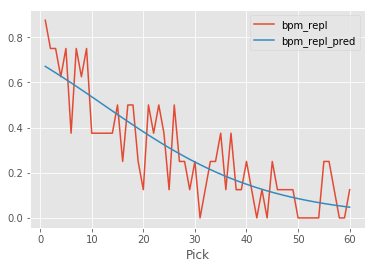

In [33]:
older_df['bpm_repl_pred'] = logm.predict()
model_df1 = older_df.groupby('Pick').agg({'bpm_repl':'mean','bpm_repl_pred':'mean'})
model_df1.plot()

The model estimate underestimates the high lottery and overestimates the rest of the first round (this is even further pronounced for the next categories below).

To combat issue, I will try to make this a curve fitting exercise instead. The best approach I found was to take a weighted average of the logistic regression and a curve fit to the form ax + b

y = 22.82917 * x + -21.83602


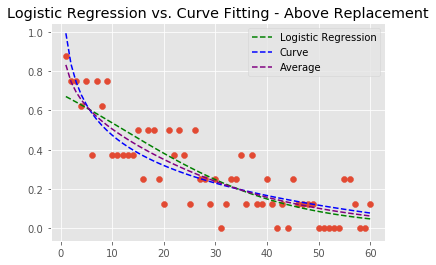

In [34]:
# define the true objective function
def objective(x, a, b):
    return a * 1/(x**0.01) + b

x = model_df1.index.values
y = model_df1['bpm_repl']

# curve fit
popt, _ = sp.optimize.curve_fit(objective, x, y)
# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b))

x_line = range(1, 60, 1)
y_line = objective(x, a, b)

plt.scatter(x,y)
plt.plot(x,model_df1['bpm_repl_pred'],'--',color='green')
plt.plot(x, y_line, '--', color='blue')
plt.plot(x, (model_df1['bpm_repl_pred']+y_line)/2, '--', color='purple')
plt.title('Logistic Regression vs. Curve Fitting - Above Replacement')
plt.legend(['Logistic Regression','Curve','Average'])

model_df1['bpm_repl_curve'] = y_line
model_df1['bpm_repl_avg'] = (model_df1['bpm_repl_pred']+y_line)/2

Sum of squared error for each of the lines

In [35]:
print('Model: ',round(sum(((model_df1['bpm_repl'] - model_df1['bpm_repl_pred']))**2),2))
print('Curve: ',round(sum((y - y_line)**2),2))
print('Average',round(sum((y - (model_df1['bpm_repl_pred']+y_line)/2)**2),2))

Model:  0.9
Curve:  0.85
Average 0.82


Next I'll take a look at drafting a player who is at least above average.

In [36]:
X = sm.add_constant(older_df['Pick'])
y = older_df['bpm_avg']
logm=sm.GLM(y,X,family=sm.families.Binomial()).fit()
print(logm.summary())
print()
print('Baseline accuracy: ',1-round(y.mean(),2))
print('Model accuracy: ',round((y == logm.predict().round()).mean(),2))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                bpm_avg   No. Observations:                  480
Model:                            GLM   Df Residuals:                      478
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -190.53
Date:                Mon, 28 Jun 2021   Deviance:                       381.05
Time:                        15:18:04   Pearson chi2:                     509.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3559      0.224     -1.590      0.112      -0.794       0.083
Pick          -0.0508      0.009     -5.905      0.0

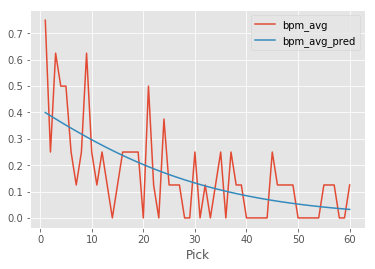

In [37]:
older_df['bpm_avg_pred'] = logm.predict()
model_df2 = older_df.groupby('Pick').agg({'bpm_avg':'mean','bpm_avg_pred':'mean'})
model_df2.plot()

Curve fitting

y = 0.81571 * x + -0.03122


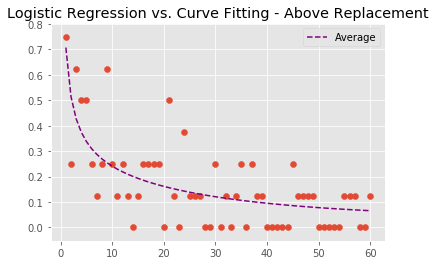

In [38]:
# define the true objective function
def objective(x, a, b):
    return a * 1/(x**0.5) + b

# model_df = pd.DataFrame(total_df.groupby(['Rank'])['stay_ind'].mean())

x = model_df2.index.values
y = model_df2['bpm_avg']

# curve fit
popt, _ = sp.optimize.curve_fit(objective, x, y)
# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b))

x_line = range(1, 60, 1)
y_line = objective(x, a, b)

plt.scatter(x,y)
# plt.plot(x,model_df2['bpm_avg_pred'],'--',color='green')
# plt.plot(x, y_line, '--', color='blue')
plt.plot(x, (model_df2['bpm_avg_pred']*0.2+y_line*0.8), '--', color='purple')
plt.title('Logistic Regression vs. Curve Fitting - Above Replacement')
plt.legend(['Average'])

model_df2['bpm_avg_curve'] = y_line
model_df2['bpm_avg_avg'] = (model_df2['bpm_avg_pred']*0.2+y_line*0.8)

Squared Errors

In [39]:
print('Model: ',round(sum(((model_df2['bpm_avg'] - model_df2['bpm_avg_pred']))**2),2))
print('Curve: ',round(sum((y - y_line)**2),2))
print('Average',round(sum((y - (model_df2['bpm_avg_pred']*0.2+y_line*0.8))**2),3))

Model:  1.01
Curve:  0.9
Average 0.884


Lastly, I'll take a look at the probability of drafting someone who is a good starter or better

In [40]:
X = sm.add_constant(older_df['Pick'])
y = older_df['bpm_good']
logm=sm.GLM(y,X,family=sm.families.Binomial()).fit()
print(logm.summary())
print()
print('Baseline accuracy: ',1-round(y.mean(),2))
print('Model accuracy: ',round((y == logm.predict().round()).mean(),2))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               bpm_good   No. Observations:                  480
Model:                            GLM   Df Residuals:                      478
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -90.018
Date:                Mon, 28 Jun 2021   Deviance:                       180.04
Time:                        15:18:05   Pearson chi2:                     862.
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0711      0.316     -3.393      0.001      -1.690      -0.452
Pick          -0.0805      0.017     -4.708      0.0

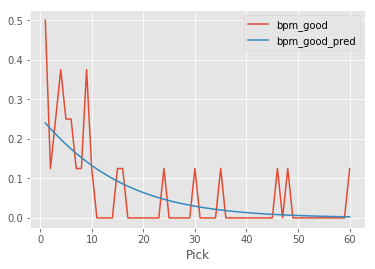

In [41]:
older_df['bpm_good_pred'] = logm.predict()
model_df3 = older_df.groupby('Pick').agg({'bpm_good':'mean','bpm_good_pred':'mean'})
model_df3.plot()

Curve fitting

y = 0.54014 * x + 0.01620


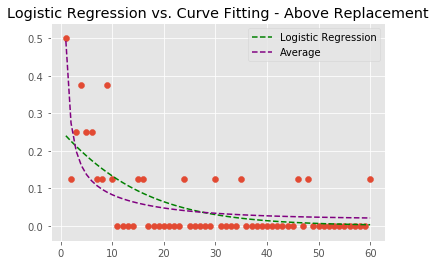

In [42]:
# define the true objective function
def objective(x, a, b):
    return a * 1/(x**1) + b

# model_df = pd.DataFrame(total_df.groupby(['Rank'])['stay_ind'].mean())

x = model_df3.index.values
y = model_df3['bpm_good']

# curve fit
popt, _ = sp.optimize.curve_fit(objective, x, y)
# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b))

x_line = range(1, 60, 1)
y_line = objective(x, a, b)

plt.scatter(x,y)
plt.plot(x,model_df3['bpm_good_pred'],'--',color='green')
# plt.plot(x, y_line, '--', color='blue')
plt.plot(x, (model_df3['bpm_good_pred']*0.2+y_line*0.8), '--', color='purple')
plt.title('Logistic Regression vs. Curve Fitting - Above Replacement')
plt.legend(['Logistic Regression','Average'])

model_df3['bpm_good_curve'] = y_line
model_df3['bpm_good_avg'] = (model_df3['bpm_good_pred']*0.2+y_line*0.8)

In [43]:
print('Model: ',round(sum(((model_df2['bpm_avg'] - model_df2['bpm_avg_pred']))**2),2))
print('Curve: ',round(sum((y - y_line)**2),2))
print('Average',round(sum((y - (model_df2['bpm_avg_pred']*0.2+y_line*0.8))**2),3))

Model:  1.01
Curve:  0.33
Average 0.327


### 6. Final Estimates

I'll bring these probabilities together into a final table

In [44]:
model_df4 = pd.concat([model_df1,model_df2,model_df3],axis=1)[['bpm_repl','bpm_avg','bpm_good','bpm_repl_avg','bpm_avg_avg','bpm_good_avg']].round(2)
model_df4.columns =['Actual Rep+','Actual Avg+','Act Good+','Pred Rep+','Pred Avg+','Pred Good+']
model_df4

,Actual Rep+,Actual Avg+,Act Good+,Pred Rep+,Pred Avg+,Pred Good+
Pick,,,,,,
1,0.88,0.75,0.50,0.83,0.71,0.49
2,0.75,0.25,0.12,0.75,0.51,0.27
3,0.75,0.62,0.25,0.69,0.43,0.20
4,0.62,0.50,0.38,0.65,0.37,0.16
5,0.75,0.50,0.25,0.62,0.34,0.14
6,0.38,0.25,0.25,0.59,0.31,0.12
7,0.75,0.12,0.12,0.57,0.29,0.11
8,0.62,0.25,0.12,0.55,0.27,0.10
9,0.75,0.62,0.38,0.52,0.25,0.09


Here is a visual of the actual results by draft pick, along with the median draft spot for each player outcome

In [45]:
def bucket2(x):
    if x['bpm_good'] == 1:
        return '3. Good Starter+'
    elif x['bpm_avg'] == 1:
        return '2. Above Average'
    elif x['bpm_repl'] == 1:
        return '1. Above Replacement'
    else:
        return '0. Did Not Stay'
    
older_df['bpm_bucket2'] = older_df.apply(bucket2,axis=1)

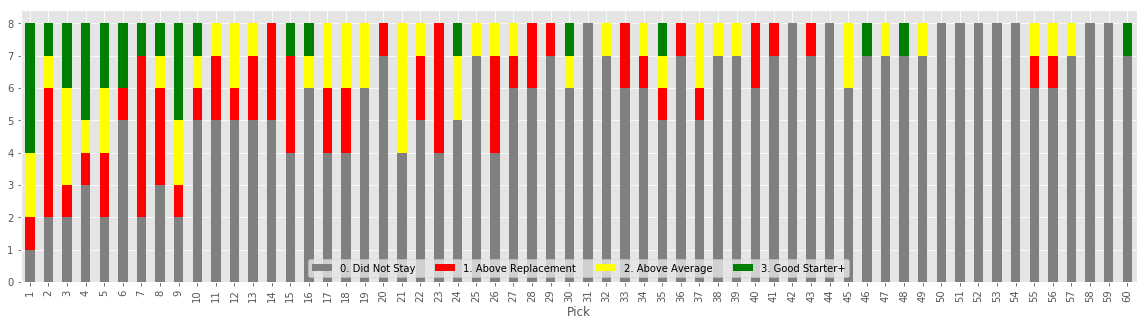

In [46]:
chart_df = pd.DataFrame(older_df.groupby(['Pick','bpm_bucket2'])['stay_ind'].count()).reset_index()
pd.pivot_table(chart_df,index='Pick',columns='bpm_bucket2',values='stay_ind',aggfunc='sum').\
plot(kind='bar',stacked=True, figsize=(20,5),color=['Gray','Red','Yellow','Green'])
plt.legend(loc='lower center',ncol=4)

In [47]:
older_df.groupby(['bpm_bucket2'])['Pick'].median()

bpm_bucket2
0. Did Not Stay         36.5
1. Above Replacement    15.0
2. Above Average        21.0
3. Good Starter+         6.5
Name: Pick, dtype: float64

And below is a visual of the predicted probabilities 

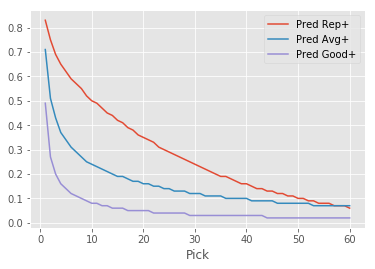

In [48]:
model_df4[['Pred Rep+','Pred Avg+','Pred Good+']].plot()

### 7. 2021 Knicks Picks

As a Knicks fan, I'm curious to see what this means for their picks this year (19th, 21st and 32nd).

The probability of getting at least one replacement-level-or-better player (67%) is about on a par with having the 4th pick

In [49]:
round(1-(1-0.36)*(1-0.34)*(1-.22),2)

0.67

For an average-or-better player we are again in the ballpark (38%) of about the 4th pick

In [50]:
round(1-(1-0.17)*(1-0.16)*(1-.11),2)

0.38

For a good starter or better, the value is a little bit lower (12% - around the 6th pick), given the steepness of this curve.

In [51]:
round(1-(1-0.05)*(1-0.05)*(1-.03),2)

0.12